In [16]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

from numpy.linalg import norm
from math import sqrt

**Huge diffusion file in a google disk**

In [17]:
def make_df_get_Dt(path, N):
    df = pd.read_csv(path, skiprows=[0,1, 2])

    with open(path) as f:
        f.readline()
        line = f.readline()

    Dt = float(line.split(':')[-1][:-1])    # шаг по времени для соседних строчек в диффузии

    return df, Dt

In [18]:
path1 = './graphs/diff_N100_t50_interval10dt.csv'
path2 = './graphs/diff_N_100_dt0_00025.csv'
N = 100

df1, Dt1 = make_df_get_Dt(path=path1, N=N)
df2, Dt2 = make_df_get_Dt(path=path2, N=N)

In [19]:
df1.shape

(6000, 400)

In [20]:
df2.shape

(45000, 400)

**Условие чтобы не было list index out of range для пандаса: предыдущее + step <= количество строк, если поделить пополам количество строчеки взять чуток поменьше, то получится все норм. Это связно с тем, что для подсчета расстояние надо делать row_numb + step, а step - это через сколько строчек по датасету я перепрыгиваю.**


In [21]:
def calculate_all_means(max_step, df, Dt, interval_for_step=10):
    '''
    Возвращает массив из усредненного по всем перемещениям для каждой частицы и затем по всем частиц из перемещений для разных времен перемещения
    и массив отрезков времени для которых как раз получено значение перемещения.
    df: pd.Dataframe
    Dt: расстояние по времени между двумя соседними строчками в датафрейме
    '''

    steps = [step for step in range(1, max_step + 1, interval_for_step)]    # через такое количество строчек я смотрю перемещение-проходясь по циклу я для разных времен перемещения получаю значения
    # print(steps)
    
    all_means = []
    for step in steps:
        part_dict = {}
        for i in range(N):
            part_dict[i] = np.array([])
        
        for row_numb in steps:
            for p_numb in range(N):
                row = df.iloc[row_numb]
                x = row[str(p_numb) + 'x']
                y = row[str(p_numb) + 'y']
                z = row[str(p_numb) + 'z']
                pos = np.array([x, y, z])

                row_next = df.iloc[row_numb + step]     # берем для той же частицы с шагом step ряд
                x_next = row_next[str(p_numb) + 'x']
                y_next = row_next[str(p_numb) + 'y']
                z_next = row_next[str(p_numb) + 'z']
                pos_next = np.array([x_next, y_next, z_next])
                
                s_square = norm(pos_next - pos) ** 2
                part_dict[p_numb] = np.append(part_dict[p_numb], s_square)

        mean_dict = {}
        for i in range(N):
            mean_dict[i] = part_dict[i].mean()

        total_mean_for_step = np.array(list(mean_dict.values())).mean()

        all_means.append(total_mean_for_step)

    return all_means, Dt * np.array(steps)
    

ceil(max / interval) - количество точек в графике

In [22]:
all_means1, dt_of_steps1 = calculate_all_means(max_step=2950, df=df1, Dt=Dt1, interval_for_step=59)

In [23]:
all_means2, dt_of_steps2 = calculate_all_means(max_step=22500, df=df2, Dt=Dt2, interval_for_step=225)

In [ ]:
def calculate_k(x, y, through_zero=False):
    '''Вычисление коэффициентов для аппроксимации зависимостью y = kx + b'''
    n = len(x)
    m_x = x.mean()
    m_y = y.mean()
    m_xx = (x * x). mean()
    m_yy = (y * y).mean()
    m_xy = (x * y).mean()
    m_x_m_x = x.mean() * x.mean()
    m_y_m_y = y.mean() * y.mean()

    k = 0
    s_k = 0
    b = 0
    s_b = 0

    if through_zero:
        k = m_xy / m_xx
        s_k = (1 / sqrt(n)) * sqrt((m_yy / m_xx) - k ** 2)
        return [k, s_k]

    else:
        k = (m_xy - m_x * m_y) / (m_xx - m_x_m_x)
        b = m_y - k * m_x

        s_k = (1 / sqrt(n)) * sqrt((m_yy - m_y_m_y) / (m_xx - m_x_m_x) - k ** 2)
        s_b = s_k * sqrt(m_xx - m_x_m_x)
        return [k, s_k, b, s_b]

In [ ]:
k1, _, b1, _ = calculate_k(np.array(dt_of_steps1), np.array(all_means1))
k2, _, b2, _ = calculate_k(np.array(dt_of_steps2), np.array(all_means2))

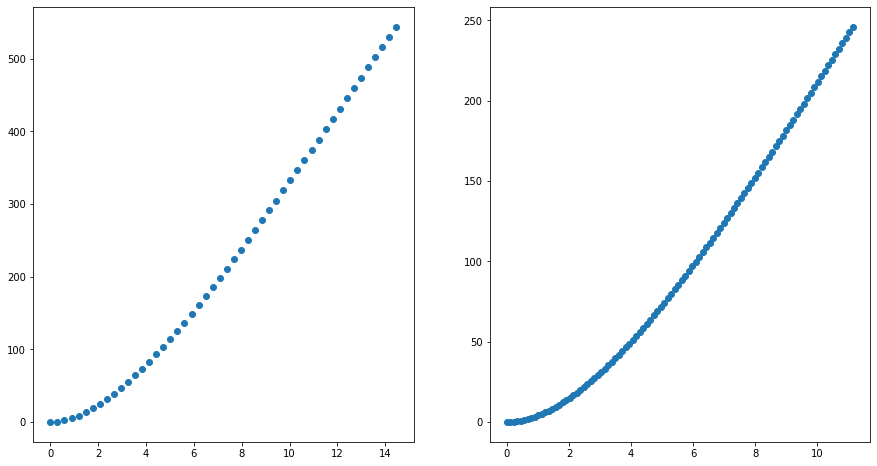

In [24]:
sp = None
plt.figure(figsize=(15, 8))

sp = plt.subplot(1, 2, 1)
plt.scatter(dt_of_steps1, all_means1)
sp = plt.subplot(1, 2, 2)
plt.scatter(dt_of_steps2, all_means2)

plt.show()

Время когда парабола переходит в прямую - это время свободного пробега. Самый простой вариант это понять - в логарифмических координатах. Когда у нас парабола - это s^2 = t^2, то есть это просто свободное движение частицы. Короче вот такая вот парабола это правильно

Сейчас задача - построить достаточно широко по координате delta_t перемещения, чтобы было видно нормально и прямую и параболу

In [29]:
x = np.log(dt_of_steps2)
y = np.log(all_means2)
plt.figure(figsize=(15, 8))

plt.scatter(x, y)

plt.show()


100

100